In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.tools import add_constant
import pickle
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv', index_col=0)

In [3]:
for column in ['body_type', 'condition', 'isTradeSeller', 'make', 'model',
               'transmission', 'location', 'doors', 'manufactured_year', 'seats']:
    df[column] = df[column].astype('category')
    
for column in ['co2Emissions', 'mileage']:
    df[column] = df[column].astype('int64', copy=False)

df.engine_size = df.engine_size.astype('float64')

In [4]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4419 entries, 3742 to 4869
Data columns (total 13 columns):
body_type            4419 non-null category
co2Emissions         4419 non-null int64
condition            4419 non-null category
doors                4419 non-null category
engine_size          4419 non-null float64
isTradeSeller        4419 non-null category
make                 4419 non-null category
manufactured_year    4419 non-null category
mileage              4419 non-null int64
model                4419 non-null category
seats                4419 non-null category
transmission         4419 non-null category
location             4419 non-null category
dtypes: category(10), float64(1), int64(2)
memory usage: 200.7 KB


In [6]:
X_train.shape

(4419, 13)

In [7]:
X_train.describe()

,co2Emissions,engine_size,mileage
count,4419.000000,4419.000000,4419.000000
mean,137.881195,1.560206,10683.328129
std,42.588843,0.833650,9388.897615
min,85.000000,0.900000,1.000000
25%,114.000000,1.000000,3841.000000
50%,127.000000,1.400000,8787.000000
75%,148.000000,1.600000,14784.500000
max,452.000000,6.750000,145000.000000


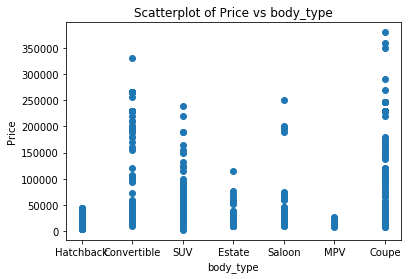

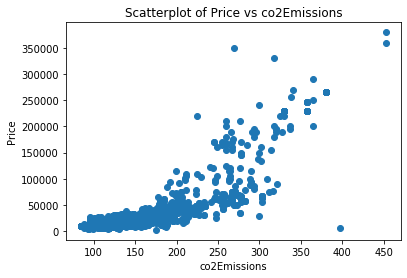

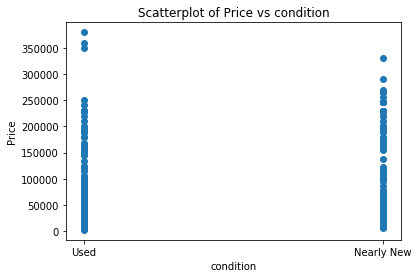

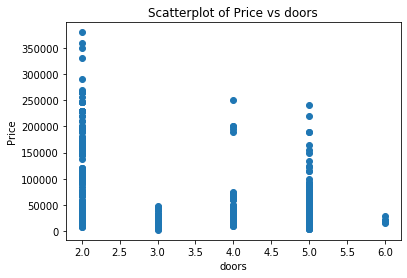

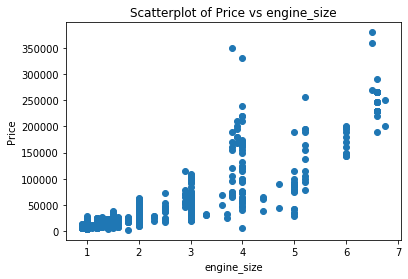

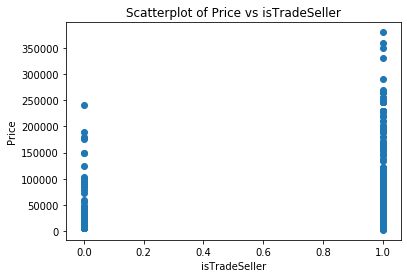

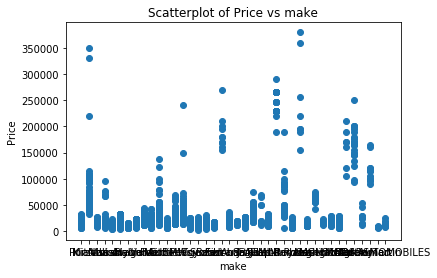

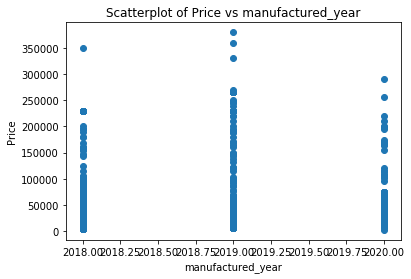

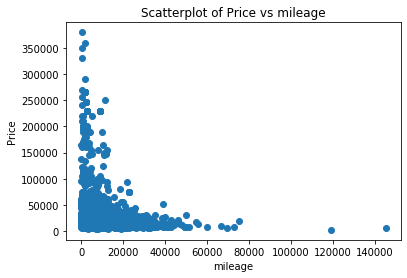

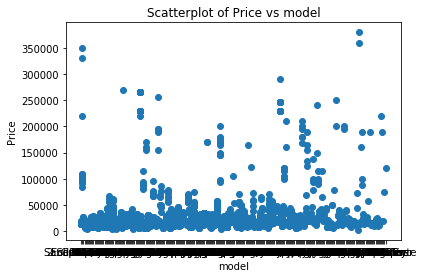

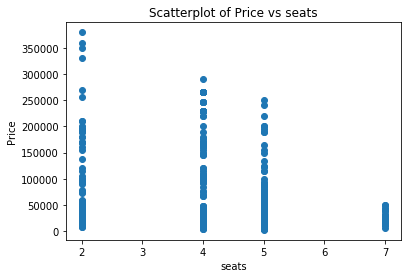

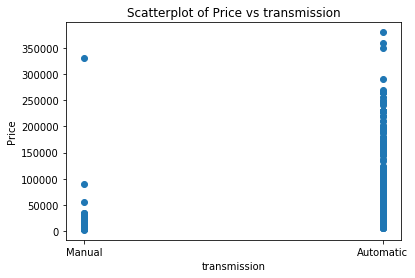

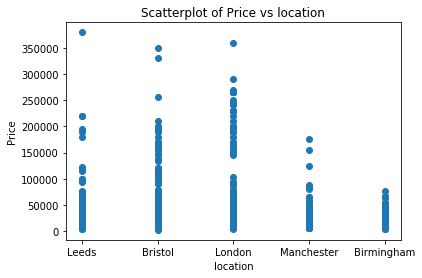

In [8]:
for column in X_train:
    #if (X[column].dtype == 'int64') | (X[column].dtype == 'float64'):
    plt.scatter(X_train[column], y_train)
    plt.xlabel(str(column))
    plt.ylabel("Price")
    plt.title(f"Scatterplot of Price vs {column}")
    plt.show()
    

Whilst scatterplots can be a little misleading in trying to ascertain how independent variables interact with the dependent variable, as it is not possible to view any interactions between independent variables that affect the target. However they can help give an insight into the data.

The plots seem to indicate a non-linear relationship for some variables. So it is worth taking note that a polynomial transformation could lead to a better model.

There appears to be an outlier on the CO2 emissions and transmission plots. This has been noted as something that may need investigating.

Text(0.5, 1.0, 'Histogram of price')

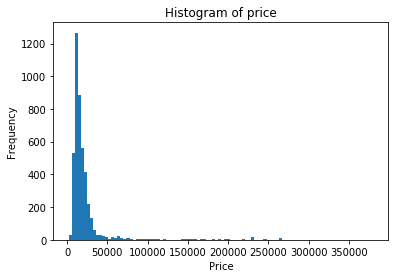

In [9]:
_ = plt.hist(y_train, bins=100)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histogram of price")

# Why do this?

In [10]:
#Scale the data to allow for better coefficient interpretation and quicker training
columns_to_scale = ['co2Emissions', 'mileage', 'engine_size']
scaler = StandardScaler()
array_train_columns = scaler.fit_transform(X_train[columns_to_scale])
array_test_columns = scaler.transform(X_test[columns_to_scale])

scaled_train_columns = pd.DataFrame(data=array_train_columns, columns=columns_to_scale)
scaled_test_columns = pd.DataFrame(data=array_test_columns, columns=columns_to_scale)


#Encoding categorical variables
columns_to_encode = ['body_type', 'condition', 'doors', 'isTradeSeller', 'make', 'manufactured_year', 'model', 'seats', 'transmission', 'location']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
array_encoded_train_columns = ohe.fit_transform(X_train[columns_to_encode])
array_encoded_test_columns = ohe.transform(X_test[columns_to_encode])

#encoded_train_columns = pd.DataFrame(data=array_encoded_train_columns, columns=ohe.get_feature_names())
#encoded_test_columns = pd.DataFrame(data=array_encoded_test_columns, columns=ohe.get_feature_names())


#combine encoded and scaled data

X_train_scaled_encoded = np.concatenate([array_train_columns, array_encoded_train_columns], axis=1)
X_test_scaled_encoded = np.concatenate([array_test_columns, array_encoded_test_columns], axis=1)


In [11]:
#A simple linear model to provide a baseline
X_train_scaled_encoded = add_constant(X_train_scaled_encoded)
X_test_scaled_encoded = add_constant(X_test_scaled_encoded)

stats_linear_model = sm.OLS(y_train, X_train_scaled_encoded)
fitted_stats_model = stats_linear_model.fit()
fitted_stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     762.1
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        08:10:18   Log-Likelihood:                -43077.
No. Observations:                4419   AIC:                         8.675e+04
Df Residuals:                    4120   BIC:                         8.866e+04
Df Model:                         298                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.078e+15   7.27e+15      0.148      0.882   -1.32e+16    1.53e+16
x1          2371.3403    271.429      8.736      0.000    1839.192    2903.488
x2          -601.1251     88.073     -6.825      0.000    -773.796    -428.454
x3          4988.7827    294.187     16.958      0.000    4412.018    5565.547
x4          1.652e+14   1.12e+15      0.148      0.882   -2.02e+15    2.35e+15
x5          1.652e+14   1.12e+15      0.148      0.882   -2.02e+15    2.35e+15
x6          1.652e+14   1.12e+15      0.148      0.882   -2.02e+15    2.35e+15
x7          1.652e+14   1.12e+15      0.148      0.882   -2.02e+15    2.35e+15
x8          1.592e+14   1.07e+15      0.148      0.882   -1.95e+15    2.27e+15
x9          1.652e+14   1.12e+15      0.148      0.882   -2.02e+15    2.35e+15
x10         1.652e+14   1.12e+15      0.148      0.882   -2.02e+15    2.35e+15
x11        -4.958e+14   3.35e+15     -0.148      0.882   -7.06e+15    6.07e+15
x12        -4.958e+14   3.35e+15     -0.148      0.882   -7.06e+15    6.07e+15
x13        -4.984e+14   3.36e+15     -0.148      0.882   -7.09e+15     6.1e+15
x14        -4.984e+14   3.36e+15     -0.148      0.882   -7.09e+15     6.1e+15
x15        -4.984e+14   3.36e+15     -0.148      0.882   -7.09e+15     6.1e+15
x16        -4.984e+14   3.36e+15     -0.148      0.882   -7.09e+15     6.1e+15
x17        -2.166e+14   1.46e+15     -0.148      0.882   -3.08e+15    2.65e+15
x18        -1.533e+15   1.03e+16     -0.148      0.882   -2.18e+16    1.88e+16
x19        -1.533e+15   1.03e+16     -0.148      0.882   -2.18e+16    1.88e+16
x20         1.872e+13   1.26e+14      0.148      0.882   -2.29e+14    2.66e+14
x21         1.315e+13   8.88e+13      0.148      0.882   -1.61e+14    1.87e+14
x22         1.795e+13   1.21e+14      0.148      0.882    -2.2e+14    2.56e+14
x23         1.876e+13   1.27e+14      0.148      0.882   -2.29e+14    2.67e+14
x24         2.125e+13   1.43e+14      0.148      0.882    -2.6e+14    3.02e+14
x25           2.4e+13   1.62e+14      0.148      0.882   -2.94e+14    3.42e+14
x26          3.11e+13    2.1e+14      0.148      0.882    -3.8e+14    4.43e+14
x27         7.831e+12   5.29e+13      0.148      0.882   -9.58e+13    1.11e+14
x28         1.149e+13   7.76e+13      0.148      0.882   -1.41e+14    1.64e+14
x29        -3.749e+12   2.53e+13     -0.148      0.882   -5.34e+13    4.59e+13
x30         1.872e+13   1.26e+14      0.148      0.882   -2.29e+14    2.66e+14
x31         3.273e+13   2.21e+14      0.148      0.882      -4e+14    4.66e+14
x32         5.025e+12   3.39e+13      0.148      0.882   -6.15e+13    7.15e+13
x33         2.551e+13   1.72e+14      0.148      0.882   -3.12e+14    3.63e+14
x34         1.975e+13   1.33e+14      0.148      0.882   -2.42e+14    2.81e+14
x35          2.33e+13   1.57e+14      0.148      0.882   -2.85e+14    3.32e+14
x3

From the output, it can be seen that the Cond. No. is 2.49 e+16. This signals that multicollinearity between the variables is present (A value below 30 is ideal). Whilst this doesn't affect the model's ability to make valid predictions but it can negatively influence the model's stability and signals that variable selection should be carried out.

In [13]:
with open('train.pickle', 'wb') as f:
    pickle.dump([X_train, y_train], f)
    
with open('test.pickle', 'wb') as f:
    pickle.dump([X_test, y_test], f)
    
with open('train_scaled.pickle', 'wb') as f:
    pickle.dump(X_train_scaled_encoded, f)

with open('test_scaled.pickle', 'wb') as f:
    pickle.dump(X_test_scaled_encoded, f)